 #

# Ci421a Project - Adult data set

#### Objective : Predict, according to some characteristics, if a person earns more than $50K per year or not


We import the librairies we need to read the datas and analyse it.

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from spacy.compat import pickle
import seaborn as sns
import numpy as np
import itertools
import warnings

warnings.filterwarnings('ignore')

We open and read the data files. We have two separated files : one containing training data and another for the test.

In [3]:
df = pd.read_csv('data/Modified_SQL_Dataset.csv')

print(df.head())

print('\nShape of train set:', df.shape)

                                               Query  Label
0                  " or pg_sleep  (  __TIME__  )  --      1
1  create user name identified by pass123 tempora...      1
2   AND 1  =  utl_inaddr.get_host_address   (    ...      1
3   select * from users where id  =  '1' or @ @1 ...      1
4   select * from users where id  =  1 or 1#"  ( ...      1

Shape of train set: (30919, 2)


## 1 - Quick dataset analysis

Now that the dataset is imported in the jupyter file, we can start exploring, digging in the datas to see what it is composed of, understand the variables in it, the possible links between them, find the target etc. This step is very important because it allows the user to understand the meaning of datasets, see if information has to be changed, or removed and also start thinking about how datas should be used with the future implemented model.

### A) Dataset cleaning and verifications



First, we check if there are repetitions of observations in the dataset.

In [4]:
df_train = df.drop_duplicates()
print('Shape of train set:', df.shape)

Shape of train set: (30919, 2)


### B) Analysis of the datasets

We can start by displaying some charcteristics in order to know the size of the dataset and what's inside.

In [5]:
columnNames = df.columns
datasetShape = df.shape
variablesTypes = df.dtypes
variablesTypesCount = df.dtypes.value_counts()

print('Column names:', columnNames, '\n')
print('Dataset shape:', datasetShape, '\n')
print('Variables types:', variablesTypes, '\n')
print('Variables types count:', variablesTypesCount)

Column names: Index(['Query', 'Label'], dtype='object') 

Dataset shape: (30919, 2) 

Variables types: Query    object
Label     int64
dtype: object 

Variables types count: object    1
int64     1
Name: count, dtype: int64


### C) Analysis of the target variable

Repartition of the target:
 Label
0    19529
1    11378
Name: count, dtype: int64

Type of this variable: int64


[Text(0, 0, 'benign'), Text(0, 1, 'SQL injection attacks')]

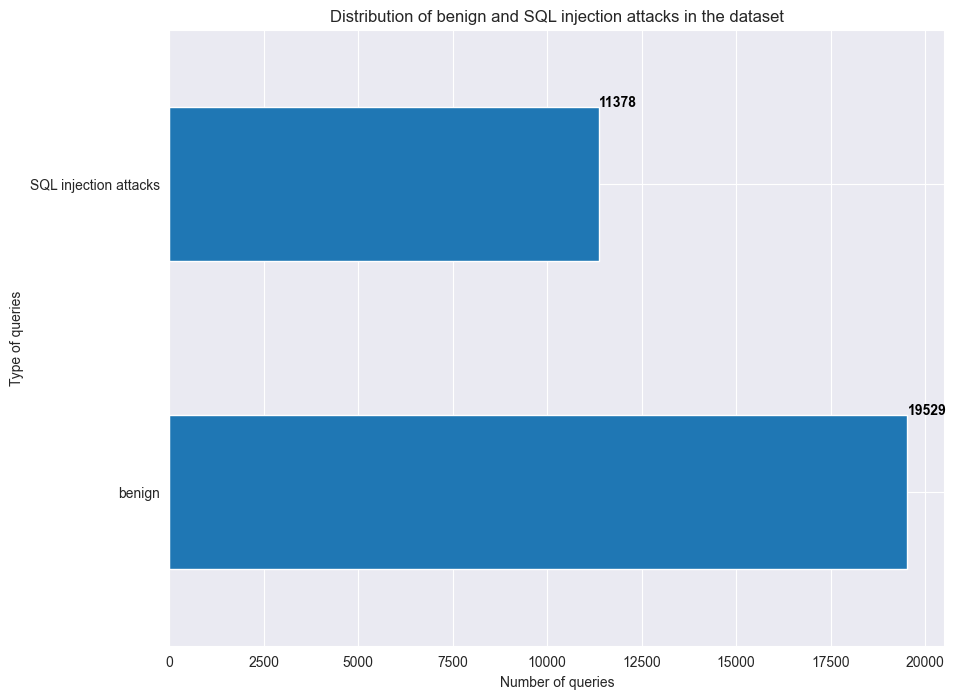

In [6]:
count_target = df_train['Label'].value_counts()
target_type = df_train['Label'].dtype

print('Repartition of the target:\n', count_target)
print('\nType of this variable:', target_type)

# plot the distribution of benign and SQL injection attacks in the dataset
plt.figure(figsize=(10, 8))
plt.title('Distribution of benign and SQL injection attacks in the dataset')
ax = count_target.plot(kind='barh')
ax.set_xlabel('Number of queries')
ax.set_ylabel('Type of queries')
for i, v in enumerate(count_target):
    ax.text(v + 3, i + .25, str(v), color='black', fontweight='bold')

# change 0 and 1 by benign and SQL injection attacks
ax.set_yticklabels(['benign', 'SQL injection attacks'])




# count_target.plot.pie(shadow=True, explode=(0.1, 0.1), autopct='%1.2f%%')




## 2 - Pre-processing

In [7]:
from sklearn.model_selection import train_test_split

First, we make a copy of the original datasets.

In [8]:
df_copy = df.copy()

We can finally build the matrices X and y for the train and  test sets

In [9]:
X = df['Query']
y = df['Label']

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# tokenize the query column

In [19]:
# import the necessary libraries
import pandas as pd
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Lire le dataset CSV
df = pd.read_csv('data/Modified_SQL_Dataset.csv')

# Sélectionner la colonne Query
queries = df['Query'].tolist()

# Initialiser le stemmer et le set de stop words
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Préprocessing du texte
processed_queries = []
padded_sequences = []
for query in queries:
    # Mettre en minuscule
    query = query.lower()

    # Tokenization
    tokens = query.split()

    # Supprimer les stop words
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    tokens = [stemmer.stem(word) for word in tokens]

    # Rejoindre les tokens
    processed_query = ' '.join(tokens)

    # Ajouter à la liste
    processed_queries.append(processed_query)

# Tokenization des queries préprocessées
tokenizer = Tokenizer()
tokenizer.fit_on_texts(processed_queries)
sequences = tokenizer.texts_to_sequences(processed_queries)

# Padding des séquences à longueur fixe
padded_sequences = pad_sequences(sequences, maxlen=50)

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)



# split the dataset into train and test sets

In [12]:
import os.path

if os.path.exists('trained_model_sql_injection.pickle'):
    print('Loading trained model...')
    model = pickle.load(open('trained_model_sql_injection.pickle', 'rb'))
    print("*************************************************************************")
    print("Model loaded, you can now go to the last cell to make a prediction")
    print("*************************************************************************")
else:
    print('Creating and training a new model...')
    print("Run all the cells below")

Loading trained model...
*************************************************************************
Model loaded, you can now go to the last cell to make a prediction
*************************************************************************


In [13]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)
# print the shape of the train and test sets
print('Shape of train set:', X_train.shape)
print('Shape of test set:', X_test.shape)


Shape of train set: (24735, 50)
Shape of test set: (6184, 50)


# create a deep neural network model with keras

In [14]:

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten
from keras.optimizers import Adam

# define input sequence shape
sequence_length = X_train.shape[1]

# define the model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=sequence_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# compile the model
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# save history
history = model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=(X_test, y_test))

# Save the model
model.save('sql_injection_model.h5')


Epoch 1/10
773/773 [==============================] - 9s 11ms/step - loss: 0.1775 - accuracy: 0.9332 - val_loss: 0.0614 - val_accuracy: 0.9846
Epoch 2/10
773/773 [==============================] - 8s 11ms/step - loss: 0.0390 - accuracy: 0.9900 - val_loss: 0.0471 - val_accuracy: 0.9859
Epoch 3/10
773/773 [==============================] - 9s 12ms/step - loss: 0.0209 - accuracy: 0.9953 - val_loss: 0.0458 - val_accuracy: 0.9874
Epoch 4/10
773/773 [==============================] - 8s 11ms/step - loss: 0.0131 - accuracy: 0.9962 - val_loss: 0.0545 - val_accuracy: 0.9887
Epoch 5/10
773/773 [==============================] - 9s 12ms/step - loss: 0.0078 - accuracy: 0.9979 - val_loss: 0.0579 - val_accuracy: 0.9884
Epoch 6/10
773/773 [==============================] - 10s 12ms/step - loss: 0.0046 - accuracy: 0.9987 - val_loss: 0.0810 - val_accuracy: 0.9897
Epoch 7/10
773/773 [==============================] - 9s 12ms/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.0803 - val_accuracy: 0.987

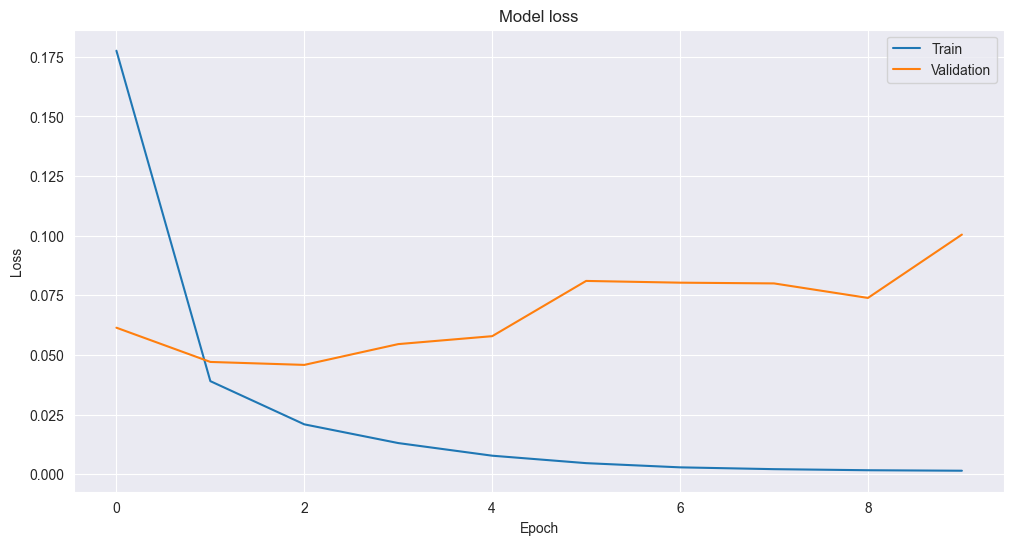

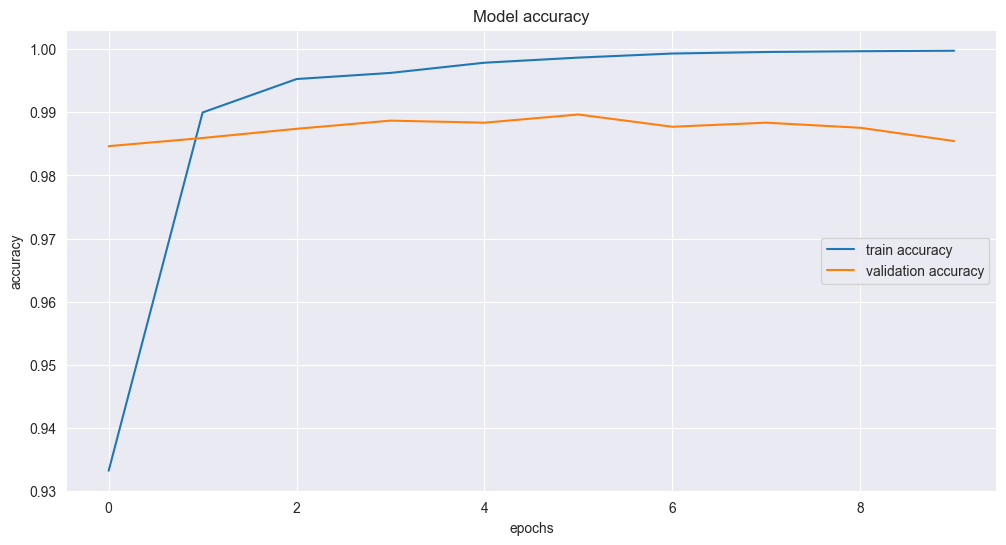

In [15]:
# Import the necessary library
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


# Afficher l'historique de l'accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train accuracy', 'validation accuracy'], loc='right')
plt.show()


In [17]:
# import necessary libraries
from keras.preprocessing.sequence import pad_sequences

# define the SQL statement
sql_statement = "SELECT * FROM employees WHERE department = 'Sales'"
sql_statement2 = "SELECT ItemName, ItemDescription FROM Items WHERE ItemNumber = 999"

# preprocess the SQL statement
# convert to lowercase
sql_statement = sql_statement.lower()
sql_statement2 = sql_statement2.lower()
# tokenize
tokens = sql_statement.split()
tokens2 = sql_statement2.split()

# remove stop words
tokens = [word for word in tokens if word not in stop_words]
tokens2 = [word for word in tokens2 if word not in stop_words]

# apply stemming
tokens = [stemmer.stem(word) for word in tokens]
tokens2 = [stemmer.stem(word) for word in tokens2]

# join the tokens
processed_query = ' '.join(tokens)
processed_query2 = ' '.join(tokens2)

# convert text to sequences
sequences = tokenizer.texts_to_sequences([processed_query])
sequences2 = tokenizer.texts_to_sequences([processed_query2])

# pad the sequences
padded_sequences = pad_sequences(sequences, maxlen=50)
padded_sequences2 = pad_sequences(sequences2, maxlen=50)

# make prediction
prediction = model.predict(padded_sequences)
prediction2 = model.predict(padded_sequences2)

if (prediction > 0.5):
    statement = 'SQL injection attack'
else:
    statement = 'benign'

if (prediction2 > 0.5):
    statement2 = 'SQL injection attack'
else:
    statement2 = 'benign'

# print the prediction
print('Prediction:', prediction, 'La requête est', statement)
print('Prediction:', prediction2, 'La requête est une', statement2)

1/1 [==============================] - 0s 24ms/step
Prediction: [[8.384695e-05]] La requête est benign
Prediction: [[0.03519583]] La requête est une benign
